## Data Analysis

(1, 150, 150)


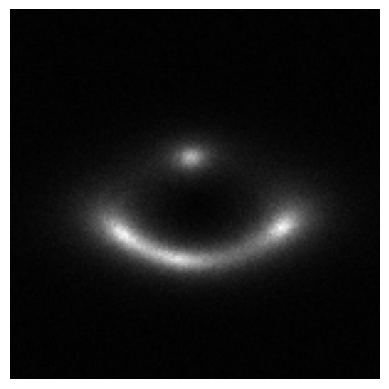

In [19]:
import numpy as np
import matplotlib.pyplot as plt

## HR

# Load the image
img = np.load("/kaggle/input/gsoc-dataset-task3-a/Dataset/HR/sample77.npy")
print(img.shape)
# Convert from (C, H, W) to (H, W, C)
img = np.transpose(img, (1, 2, 0))  

# Display the image
plt.imshow(img, cmap="gray")  # Use cmap="gray" if it's a grayscale image
plt.axis("off")  # Hide axes
plt.show()

(1, 75, 75)


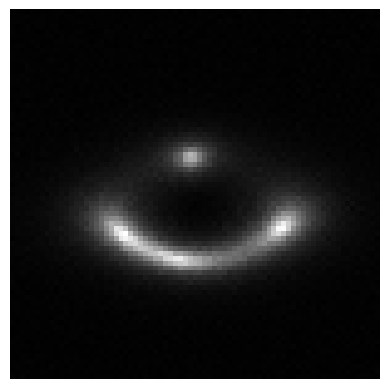

In [20]:
import numpy as np
import matplotlib.pyplot as plt

## LR

# Load the image
img = np.load("/kaggle/input/gsoc-dataset-task3-a/Dataset/LR/sample77.npy")
print(img.shape)
# Convert from (C, H, W) to (H, W, C)
img = np.transpose(img, (1, 2, 0))  

# Display the image
plt.imshow(img, cmap="gray")  # Use cmap="gray" if it's a grayscale image
plt.axis("off")  # Hide axes
plt.show()

## Configurations

In [21]:
class CFG:
    def __init__(self):
        self.lr_folder = "/kaggle/input/gsoc-dataset-task3-a/Dataset/LR"
        self.hr_folder = "/kaggle/input/gsoc-dataset-task3-a/Dataset/HR"
        self.batch_size = 16
        self.val_batch_size = 16
        self.num_workers = 4
        self.train_size = 0.7
        
        self.model_d = 56
        self.model_s = 12
        self.model_m = 4
        
        self.lr_init = 0.001
        self.epochs = 75
        self.weights_fn = "best_fsrcnn_model.pth"

config = CFG()

## Data Preparation

In [22]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import yaml
import argparse

class CustomNPYDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, set_type, train_size):
        self.lr_folder = lr_folder
        self.hr_folder = hr_folder
        self.image_fns = sorted([f for f in os.listdir(hr_folder) if f.endswith(".npy")], key=lambda x: int((x.split(".")[0]).split("ple")[1]))
        
        # Split the dataset based on set_type (train, val)
        if set_type == "train":
            self.image_fns = self.image_fns[:int(len(self.image_fns) * train_size)]
        else: # for validation
            self.image_fns = self.image_fns[int(len(self.image_fns) * train_size):]

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, idx):
        image_fn = self.image_fns[idx]
        lr_image = np.load(os.path.join(self.lr_folder, image_fn))
        hr_image = np.load(os.path.join(self.hr_folder, image_fn))

        # Normalize to float32 and convert to tensors
        lr_image = torch.tensor(lr_image, dtype=torch.float32) / 255.0
        hr_image = torch.tensor(hr_image, dtype=torch.float32) / 255.0

        return lr_image, hr_image



## Model

In [23]:
class FSRCNN(nn.Module):
    def __init__(self, d, s, m):
        super(FSRCNN, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=5, padding=2),
            nn.PReLU()
        )
        self.shrinking = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU()
        )
        self.mapping = nn.Sequential(*[nn.Sequential(nn.Conv2d(s, s, kernel_size=3, padding=1), nn.PReLU()) for _ in range(m)])
        self.expanding = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU()
        )
        self.deconv = nn.ConvTranspose2d(d, 1, kernel_size=9, stride=2, padding=4, output_padding=1)
    
    def forward(self, x):
        x = self.feature_extraction(x) # input channel is 1
        x = self.shrinking(x)
        x = self.mapping(x)
        x = self.expanding(x)
        x = self.deconv(x)
        return x

## Training

In [25]:
# Test with a low-resolution image
lr_images = torch.randn(1, 1, 75, 75)  # Simulating a batch of 1 LR image
model = model = FSRCNN(d=config.model_d, s=config.model_s, m=config.model_m)
outputs = model(lr_images)
print("LR Image Shape:", lr_images.shape)    # (1, 1, 75, 75)
print("Model Output Shape:", outputs.shape)  # (1, 1, 150, 150) ✅

LR Image Shape: torch.Size([1, 1, 75, 75])
Model Output Shape: torch.Size([1, 1, 150, 150])


In [26]:
import os
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(config):
    # Dataset and DataLoader
    train_dataset = CustomNPYDataset(
        lr_folder=config.lr_folder,
        hr_folder=config.hr_folder,
        set_type="train",
        train_size=config.train_size
    )
    val_dataset = CustomNPYDataset(
        lr_folder=config.lr_folder,
        hr_folder=config.hr_folder,
        set_type="val",
        train_size=config.train_size
    )

    print("Train Size: ", (len(train_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")
    print("Validation Size: ", (len(val_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.val_batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )

    # Model
    model = FSRCNN(d=config.model_d, s=config.model_s, m=config.model_m)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss and Optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr_init)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=20, min_lr=1e-6, verbose=True
    )

    # Training Loop
    best_val_loss = float("inf")
    for epoch in range(config.epochs):
        print(f"Epoch {epoch + 1}/{config.epochs}")
        model.train()
        train_loss = 0.0

        for lr_images, hr_images in tqdm(train_loader, desc="Training"):
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Forward pass
            outputs = model(lr_images)
            loss = criterion(outputs, hr_images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for lr_images, hr_images in tqdm(val_loader, desc="Validation"):
                lr_images, hr_images = lr_images.to(device), hr_images.to(device)

                # Forward pass
                outputs = model(lr_images)
                loss = criterion(outputs, hr_images)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        if epoch % 5 == 0:
            print(f"Training Loss: {train_loss:.6f} -||-", f"Validation Loss: {val_loss:.6f}")

        # Checkpoint and Learning Rate Scheduler
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), config.weights_fn)
            if epoch % 5 == 0:
                print(f"Saved Best Model to {config.weights_fn}")

        if epoch % 5 == 0:
            print("-" * 50)
        




In [27]:
import warnings

if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    train(config)

Train Size:  70.0 %
Validation Size:  30.0 %
Epoch 1/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 104.01it/s]


Training Loss: 0.013844 -||- Validation Loss: 0.004071
Saved Best Model to best_fsrcnn_model.pth
--------------------------------------------------
Epoch 2/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 94.63it/s] 


Epoch 3/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 100.57it/s]


Epoch 4/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 100.39it/s]


Epoch 5/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 96.32it/s] 


Epoch 6/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.44it/s] 


Training Loss: 0.003230 -||- Validation Loss: 0.003245
--------------------------------------------------
Epoch 7/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 90.97it/s] 


Epoch 8/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 101.04it/s]


Epoch 9/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 102.59it/s]


Epoch 10/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.52it/s] 


Epoch 11/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 104.36it/s]


Training Loss: 0.000802 -||- Validation Loss: 0.000946
--------------------------------------------------
Epoch 12/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 98.33it/s] 


Epoch 13/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 93.12it/s] 


Epoch 14/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 98.06it/s] 


Epoch 15/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 101.71it/s]


Epoch 16/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.06it/s] 


Training Loss: 0.000389 -||- Validation Loss: 0.000286
Saved Best Model to best_fsrcnn_model.pth
--------------------------------------------------
Epoch 17/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 97.24it/s] 


Epoch 18/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.87it/s] 


Epoch 19/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 95.28it/s] 


Epoch 20/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 102.40it/s]


Epoch 21/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 101.64it/s]


Training Loss: 0.000174 -||- Validation Loss: 0.000133
Saved Best Model to best_fsrcnn_model.pth
--------------------------------------------------
Epoch 22/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 97.56it/s] 


Epoch 23/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 97.39it/s] 


Epoch 24/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.85it/s] 


Epoch 25/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.97it/s] 


Epoch 26/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 89.28it/s] 


Training Loss: 0.000112 -||- Validation Loss: 0.000149
--------------------------------------------------
Epoch 27/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 101.68it/s]


Epoch 28/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 103.06it/s]


Epoch 29/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 107.91it/s]


Epoch 30/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 102.74it/s]


Epoch 31/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 89.91it/s] 


Training Loss: 0.000091 -||- Validation Loss: 0.000051
Saved Best Model to best_fsrcnn_model.pth
--------------------------------------------------
Epoch 32/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 91.34it/s] 


Epoch 33/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 102.30it/s]


Epoch 34/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 100.42it/s]


Epoch 35/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 102.63it/s]


Epoch 36/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 98.39it/s] 


Training Loss: 0.000080 -||- Validation Loss: 0.000035
Saved Best Model to best_fsrcnn_model.pth
--------------------------------------------------
Epoch 37/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 100.21it/s]


Epoch 38/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.60it/s] 


Epoch 39/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 107.08it/s]


Epoch 40/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 104.24it/s]


Epoch 41/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 95.93it/s] 


Training Loss: 0.000077 -||- Validation Loss: 0.000059
--------------------------------------------------
Epoch 42/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.51it/s] 


Epoch 43/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 98.94it/s] 


Epoch 44/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.75it/s] 


Epoch 45/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 107.71it/s]


Epoch 46/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 105.97it/s]


Training Loss: 0.000075 -||- Validation Loss: 0.000043
--------------------------------------------------
Epoch 47/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 106.97it/s]


Epoch 48/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 98.99it/s] 


Epoch 49/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 98.34it/s] 


Epoch 50/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 91.26it/s] 


Epoch 51/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 96.92it/s] 


Training Loss: 0.000060 -||- Validation Loss: 0.000041
--------------------------------------------------
Epoch 52/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 93.59it/s] 


Epoch 53/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 91.83it/s] 


Epoch 54/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 104.70it/s]


Epoch 55/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 96.14it/s] 


Epoch 56/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 105.71it/s]


Training Loss: 0.000065 -||- Validation Loss: 0.000073
--------------------------------------------------
Epoch 57/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 99.93it/s] 


Epoch 58/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 101.86it/s]


Epoch 59/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 91.75it/s] 


Epoch 60/75


Validation: 100%|██████████| 188/188 [00:02<00:00, 86.85it/s]


Epoch 61/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 97.02it/s] 


Training Loss: 0.000053 -||- Validation Loss: 0.000045
--------------------------------------------------
Epoch 62/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 96.85it/s] 


Epoch 63/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 94.88it/s] 


Epoch 64/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 104.23it/s]


Epoch 65/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 100.46it/s]


Epoch 66/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 103.91it/s]


Training Loss: 0.000040 -||- Validation Loss: 0.000107
--------------------------------------------------
Epoch 67/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 104.40it/s]


Epoch 68/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 100.60it/s]


Epoch 69/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 103.08it/s]


Epoch 70/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 100.13it/s]


Epoch 71/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 102.33it/s]


Training Loss: 0.000068 -||- Validation Loss: 0.000094
--------------------------------------------------
Epoch 72/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 106.17it/s]


Epoch 73/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 104.76it/s]


Epoch 74/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 103.12it/s]


Epoch 75/75


Validation: 100%|██████████| 188/188 [00:01<00:00, 103.92it/s]


## Evaluation Metrics

In [31]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm
import torch.nn.functional as F

def evaluate_metrics(config, model, dataset, device, dataset_name="Train"):
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # SSIM, PSNR, and MSE are calculated per image
        shuffle=False,
        num_workers=config.num_workers
    )

    ssim_scores = []
    psnr_scores = []
    mse_scores = []  # Added MSE storage

    model.eval()
    with torch.no_grad():
        for lr_images, hr_images in tqdm(dataloader, desc=f"Evaluating {dataset_name} Dataset"):
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Model prediction
            outputs = model(lr_images)

            # Convert tensors to numpy arrays
            hr_np = hr_images.cpu().squeeze().numpy()
            out_np = outputs.cpu().squeeze().numpy()

            # Compute SSIM and PSNR
            ssim_value = ssim(hr_np, out_np, data_range=out_np.max() - out_np.min())
            psnr_value = psnr(hr_np, out_np, data_range=out_np.max() - out_np.min())

            # Compute MSE
            mse_value = F.mse_loss(outputs, hr_images).item()  # Using PyTorch MSE

            ssim_scores.append(ssim_value)
            psnr_scores.append(psnr_value)
            mse_scores.append(mse_value)  # Store MSE

    # Compute average SSIM, PSNR, and MSE
    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)
    avg_mse = np.mean(mse_scores)  # Compute average MSE

    print(f"Average SSIM for {dataset_name} Dataset: {avg_ssim:.4f}")
    print(f"Average PSNR for {dataset_name} Dataset: {avg_psnr:.4f} dB")
    print(f"Average MSE for {dataset_name} Dataset: {avg_mse:.9f}")  # Print MSE with 9 decimals
    print("-" * 50)
    
    return avg_ssim, avg_psnr, avg_mse

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FSRCNN(d=config.model_d, s=config.model_s, m=config.model_m).to(device)
# model = LapSRN().to(device)
model.load_state_dict(torch.load(config.weights_fn))
model.eval()

train_dataset = CustomNPYDataset(
    lr_folder=config.lr_folder,
    hr_folder=config.hr_folder,
    set_type="train",
    train_size=config.train_size
)
val_dataset = CustomNPYDataset(
    lr_folder=config.lr_folder,
    hr_folder=config.hr_folder,
    set_type="val",
    train_size=config.train_size
)

print("Train Size: ", (len(train_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")
print("Validation Size: ", (len(val_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")

# Evaluate Train and Validation datasets (Now Includes MSE)
train_ssim, train_psnr, train_mse = evaluate_metrics(config, model, train_dataset, device, "Train")
val_ssim, val_psnr, val_mse = evaluate_metrics(config, model, val_dataset, device, "Validation")


Train Size:  70.0 %
Validation Size:  30.0 %


Evaluating Train Dataset: 100%|██████████| 7000/7000 [00:32<00:00, 217.03it/s]


Average SSIM for Train Dataset: 0.9563
Average PSNR for Train Dataset: 38.8570 dB
Average MSE for Train Dataset: 0.000000002
--------------------------------------------------


Evaluating Validation Dataset: 100%|██████████| 3000/3000 [00:14<00:00, 212.91it/s]

Average SSIM for Validation Dataset: 0.9563
Average PSNR for Validation Dataset: 38.8625 dB
Average MSE for Validation Dataset: 0.000000002
--------------------------------------------------


## Visualization

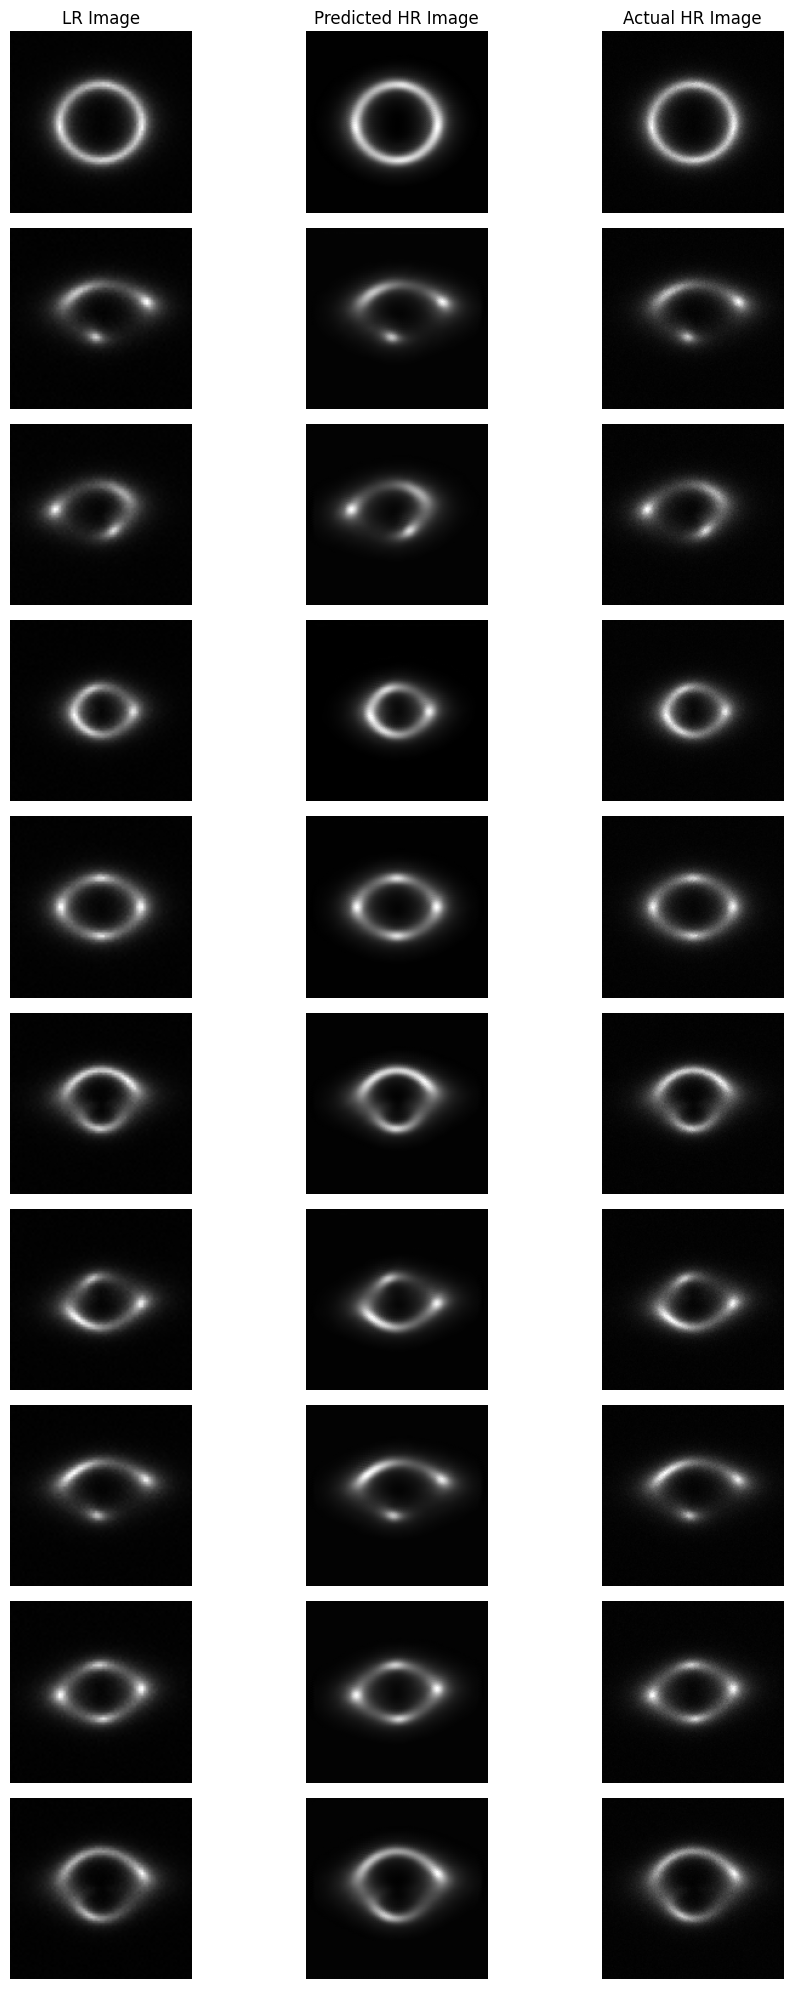

In [29]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

def visualize_predictions(config, model, dataset, device, num_images=10):
    """Displays predicted vs actual HR images for a given dataset."""
    
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # Process one image at a time for visualization
        shuffle=True,  # Randomly pick images
        num_workers=config.num_workers
    )

    model.eval()
    
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 2))
    axes[0, 0].set_title("LR Image")
    axes[0, 1].set_title("Predicted HR Image")
    axes[0, 2].set_title("Actual HR Image")

    with torch.no_grad():
        for i, (lr_images, hr_images) in enumerate(dataloader):
            if i >= num_images:  
                break  # Stop after visualizing `num_images`

            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Model prediction
            outputs = model(lr_images)

            # Convert tensors to numpy
            lr_np = lr_images.cpu().squeeze().numpy()
            pred_hr_np = outputs.cpu().squeeze().numpy()
            hr_np = hr_images.cpu().squeeze().numpy()

            # Plot images
            axes[i, 0].imshow(lr_np, cmap="gray")  # LR Image
            axes[i, 1].imshow(pred_hr_np, cmap="gray")  # Predicted HR Image
            axes[i, 2].imshow(hr_np, cmap="gray")  # Ground Truth HR Image

            for j in range(3):
                axes[i, j].axis("off")  # Remove axes

    plt.tight_layout()
    plt.show()

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FSRCNN(d=config.model_d, s=config.model_s, m=config.model_m).to(device)
model.load_state_dict(torch.load(config.weights_fn))
model.eval()

# Call function to visualize predictions
visualize_predictions(config, model, val_dataset, device, num_images=10)
